### Imports

In [148]:
#from backtesting.test import EURUSD, GOOG

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [243]:
PERIOD = 12

### Process parquet

In [266]:
import pandas as pd
import pyarrow.parquet as pq

DATA_PATH='/home/bkadmin/datasets/spatialedge-hackathon-H1/v1/' 
FROM_DATE='20181001'
TO_DATE='20191101'
SYMBOL = 'EURUSD'
TIMEFRAME = 'H1'

def read_and_process_parquet(data_path, from_date, to_date, symbol, timeframe):
    partition = ['symbol','timeframe', 'date', 'date']
    operator = ['=', '=', '>=', '<=']
    params = [symbol, timeframe, from_date, to_date]
            
    dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
    table = dataset.read()
    df = table.to_pandas()

    df['date'] = df['date'].astype(str)
    df['time'] = df['time'].astype(str)

    df['datetime'] = df['date'] + ' ' + df['time']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S')
    df.set_index('datetime', inplace=True)

    df.drop(['time', 'symbol', 'timeframe', 'date'], axis=1, inplace=True)
    df = df.sort_values('datetime')
    df.fillna(method='ffill', inplace=True)

    return df 

data = read_and_process_parquet(DATA_PATH, FROM_DATE, TO_DATE, SYMBOL, TIMEFRAME)

/tmp/ipykernel_157450/4029132073.py:15: FutureWarning: Passing 'use_legacy_dataset=True' to get the legacy behaviour is deprecated as of pyarrow 11.0.0, and the legacy implementation will be removed in a future version.
  dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
/tmp/ipykernel_157450/4029132073.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


### Create helper functions

In [267]:
#data = EURUSD.copy()

# Relative Strength Index (RSI)
#close = data.Close.values


def RSI(values, period=168):
    delta = pd.Series(values).diff()
    gain = delta.where(delta>0.0)
    #gain.fillna(0, inplace=True) 
    loss = -delta.where(delta<0.0)
    #loss.fillna(0, inplace=True) #TODO: instead of replacing with 0, remove those vaues
    loss
    avg_gain = gain.rolling(period, min_periods=1).mean() # average gain over 7 day period (168hr) 
    avg_gain.fillna(0, inplace=True)
    avg_loss = loss.rolling(period, min_periods=1).mean() # average loss over 7 day period (168hr)
    avg_loss.fillna(0.000000001, inplace=True)
    rs = (avg_gain/avg_loss)
    rsi = 100-(100/(1+rs))
   
    return rsi

def SMA(values, n):
    
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

def Stochastic_Oscillator(values, period=168):
    '''Calculates stochastic oscillator'''
    time_period = period
    data = pd.Series(values)
    if len(values) < time_period:
        time_period = len(values)
    lowest_close_in_period = data.rolling(time_period, min_periods=1).min()
    highest_close_in_period = data.rolling(time_period, min_periods=1).max()
    so = ((data-lowest_close_in_period)/(highest_close_in_period-lowest_close_in_period))*100
    return so


def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


### Create features

In [268]:
from feature_engine.timeseries.forecasting import LagFeatures
import numpy as np

data.columns = ['Open','High','Low','Close','Volume']
rsi = RSI(data.Close, 168)
so14 = Stochastic_Oscillator(data.Close, 14)
so28 = Stochastic_Oscillator(data.Close, 28)
sma5 = SMA(data.Close, 5)
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
upper, lower = BBANDS(data, 20, 2)

data['X_RSI'] = rsi
data['X_SO14'] = so14
data['X_SO28'] = so28
data['X_DELTA_SO14'] = (so14-so28)/data.Close.values

data['X_SMA5']  = sma5
data['X_SMA10'] = sma10
data['X_SMA20'] = sma20
data['X_SMA50'] = sma50
data['X_DELTA_SMA10'] = (sma10-sma20) / data.Close.values
data['X_DELTA_SMA20'] = (sma50-sma20) / data.Close.values

data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - data.Close) / data.Close
data['X_BB_lower'] = (lower - data.Close) / data.Close
data['X_BB_width'] = (upper - lower) / data.Close

day = 24
month = 30 * day
year = (365.2425) * day

data['X_Day_Sin'] = np.sin(data.index.hour * (2 * np.pi / day))
data['X_Day_Cos'] = np.cos(data.index.hour * (2 * np.pi / day))
data['X_Day_Tan'] = np.tan(data.index.hour * (2 * np.pi / day))

data['X_Day_Sin'] = np.sin(data.index.day * (2 * np.pi / month))
data['X_Day_Cos'] = np.cos(data.index.day * (2 * np.pi / month))
data['X_Day_Tan'] = np.tan(data.index.day * (2 * np.pi / month))

data['X_Year_Sin'] = np.sin(data.index.dayofyear * (2 * np.pi / year))
data['X_Year_Cos'] = np.cos(data.index.dayofyear * (2 * np.pi / year))
data['X_Year_Tan'] = np.tan(data.index.dayofyear * (2 * np.pi / year))

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data.head()

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_BB_lower,X_BB_width,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_day,X_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2018-10-01 00:00:00,1.160535,1.160995,1.160435,1.160690,9521.390031,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.008727,0.999962,0.008727,0.195138,0.980776,0.198963,0,0
2018-10-01 01:00:00,1.160680,1.160870,1.159540,1.160070,14066.040011,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,0.008727,0.999962,0.008727,0.195138,0.980776,0.198963,0,1
2018-10-01 02:00:00,1.160070,1.160305,1.159615,1.159670,9543.470012,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,0.008727,0.999962,0.008727,0.195138,0.980776,0.198963,0,2
2018-10-01 03:00:00,1.159650,1.159795,1.159340,1.159630,7843.380026,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,0.008727,0.999962,0.008727,0.195138,0.980776,0.198963,0,3
2018-10-01 04:00:00,1.159640,1.159650,1.159130,1.159535,5721.100008,0.0,0.0,0.0,0.0,1.159919,...,NaN,NaN,0.008727,0.999962,0.008727,0.195138,0.980776,0.198963,0,4


In [269]:
# Lagging price indicator
#data['X_LAG1'] = data.Close.shift(24)
lf = LagFeatures(periods=PERIOD, variables = ["Close"])

In [270]:
data.index.value_counts()


datetime
2019-03-11 00:00:00    2
2018-10-01 00:00:00    1
2019-06-24 23:00:00    1
2019-06-24 22:00:00    1
2019-06-24 21:00:00    1
                      ..
2019-02-11 08:00:00    1
2019-02-11 07:00:00    1
2019-02-11 06:00:00    1
2019-02-11 05:00:00    1
2019-11-01 20:00:00    1
Name: count, Length: 6781, dtype: int64

In [271]:
data = data[~data.index.duplicated(keep='first')]
data[data.index=='2019-03-11 00:00:00']

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_BB_lower,X_BB_width,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_day,X_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2019-03-11,1.12317,1.12324,1.122305,1.12279,11678.519996,46.108316,46.306306,72.585097,-23.404902,1.123171,...,-0.002674,0.004807,0.095846,0.995396,0.096289,0.050154,0.998742,0.050217,0,0


In [272]:
data = lf.fit_transform(data)
data = data.dropna()
data.dropna().astype(float)

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_BB_width,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_day,X_hour,Close_lag_12
datetime,,,,,,,,,,,,,,,,,,,,,
2018-10-03 01:00:00,1.154460,1.157480,1.153600,1.157025,18663.270018,49.812177,100.000000,88.968825,9.534085,1.155262,...,0.004610,0.026177,0.999657,0.026186,0.196544,0.980495,0.200454,2.0,1.0,1.153305
2018-10-03 02:00:00,1.157005,1.159380,1.156445,1.158505,26200.070032,50.981363,100.000000,100.000000,0.000000,1.156021,...,0.005498,0.026177,0.999657,0.026186,0.196544,0.980495,0.200454,2.0,2.0,1.155650
2018-10-03 03:00:00,1.158500,1.158840,1.157925,1.158005,15207.119969,51.246388,88.193625,92.902768,-4.066600,1.156607,...,0.006228,0.026177,0.999657,0.026186,0.196544,0.980495,0.200454,2.0,3.0,1.155865
2018-10-03 04:00:00,1.158005,1.158325,1.157535,1.157780,14165.869980,51.838611,82.880756,89.709013,-5.897716,1.157153,...,0.006432,0.026177,0.999657,0.026186,0.196544,0.980495,0.200454,2.0,4.0,1.155070
2018-10-03 05:00:00,1.157775,1.158950,1.157620,1.158660,22481.900018,52.037868,100.000000,100.000000,0.000000,1.157995,...,0.006310,0.026177,0.999657,0.026186,0.196544,0.980495,0.200454,2.0,5.0,1.154270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01 16:00:00,1.116870,1.117095,1.116230,1.116820,15445.710016,54.953066,98.795181,98.795181,0.000000,1.115618,...,0.002900,0.008727,0.999962,0.008727,0.216881,0.976198,0.222169,4.0,16.0,1.116430
2019-11-01 17:00:00,1.116825,1.116905,1.116120,1.116185,11067.350020,54.955519,81.793842,81.793842,0.000000,1.116229,...,0.002908,0.008727,0.999962,0.008727,0.216881,0.976198,0.222169,4.0,17.0,1.116415
2019-11-01 18:00:00,1.116190,1.116640,1.115880,1.116355,7992.340005,54.758643,86.345382,86.345382,0.000000,1.116554,...,0.002888,0.008727,0.999962,0.008727,0.216881,0.976198,0.222169,4.0,18.0,1.116185


# Feature Importance

### Create matrix

In [273]:


def get_X(data):
    return data.filter(like='X').values

def get_y(data):
    y = data.Close.pct_change(PERIOD).shift(-PERIOD)
    y[y.between(-.004,.004)] = 0
    y[y > 0] = 1
    y[y < 0] = -1
    return y

def get_clean_Xy(df):
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

### Test model

In [274]:
column_names = tuple(data.columns[5:])

In [275]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

# Assuming y_train and X_train are both numpy arrays
data2 = np.column_stack((y_train, X_train))

# Xtrain
data2 = pd.Series(y_train) + pd.DataFrame(X_train) 

from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(penalty='l2', C=1.0)
model_lr.fit(X_train, y_train)

/home/bkadmin/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [276]:
feature_importance = model_lr.coef_
feature_importance

array([[ 2.73036775e-02,  8.78076939e-02, -8.71837556e-02,
        -9.74887353e-02, -2.55041615e-01, -2.55555223e-01,
        -2.57609045e-01, -2.61544482e-01,  1.78520894e-03,
        -3.49073210e-03,  7.71153232e-05, -4.43215332e-03,
        -5.57737905e-04, -3.87441541e-03, -2.98358302e-02,
        -2.95659701e-01, -3.09380708e-02,  1.26167486e-01,
        -3.26623544e-01,  1.33771413e-01,  6.66350545e-02,
        -4.06695603e-02],
       [-1.09715811e-02, -2.20848140e-02,  2.09578758e-02,
         2.49928126e-02,  2.96827447e-01,  2.97313649e-01,
         2.99459136e-01,  3.02770875e-01, -1.88859081e-03,
         2.93704189e-03,  5.66039988e-04,  4.38472356e-03,
        -1.58919424e-04,  4.54364298e-03,  8.47471610e-02,
         3.35385703e-01,  8.70252533e-02, -2.57482132e-01,
         3.96239600e-01, -2.71721474e-01, -1.39061108e-01,
         4.23175852e-02],
       [-1.63320964e-02, -6.57228799e-02,  6.62258798e-02,
         7.24959227e-02, -4.17858317e-02, -4.17584257e-02,
    

In [277]:
import numpy as np

feature_importance = np.abs(feature_importance)
feature_ranking = np.argsort(feature_importance)[0][::-1]

# Create a dictionary to store feature importances with their corresponding column names
feature_importance_dict = {column_name: importance for column_name, importance in zip(column_names, feature_importance[0])}
feature_importance_dict


{'X_RSI': 0.027303677500580544,
 'X_SO14': 0.08780769391783332,
 'X_SO28': 0.08718375556631097,
 'X_DELTA_SO14': 0.09748873529813908,
 'X_SMA5': 0.25504161507262957,
 'X_SMA10': 0.2555552229024362,
 'X_SMA20': 0.2576090449448489,
 'X_SMA50': 0.2615444823384255,
 'X_DELTA_SMA10': 0.00178520894063969,
 'X_DELTA_SMA20': 0.0034907321031381017,
 'X_MOM': 7.71153231575937e-05,
 'X_BB_upper': 0.004432153317959127,
 'X_BB_lower': 0.0005577379051825433,
 'X_BB_width': 0.0038744154127763933,
 'X_Day_Sin': 0.029835830198369055,
 'X_Day_Cos': 0.2956597009621791,
 'X_Day_Tan': 0.030938070777145044,
 'X_Year_Sin': 0.12616748647819534,
 'X_Year_Cos': 0.32662354413081973,
 'X_Year_Tan': 0.13377141286581956,
 'X_day': 0.06663505445993523,
 'X_hour': 0.040669560279260546}

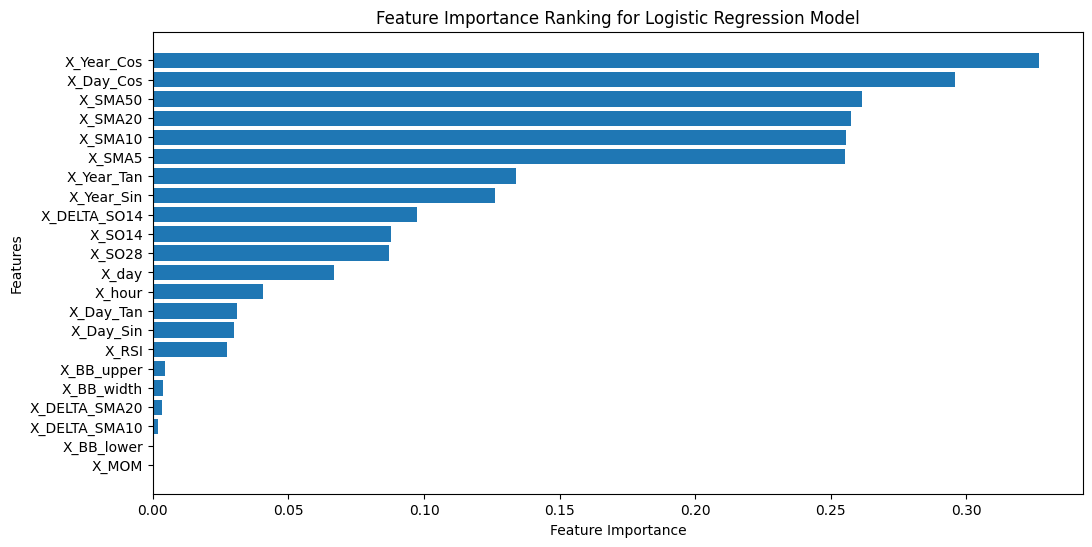

In [278]:
import matplotlib.pyplot as plt

# Sort feature importances in descending order
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted feature names and importance scores
sorted_feature_names = [item[0] for item in sorted_importance]
sorted_importance_scores = [item[1] for item in sorted_importance]

# Create a bar plot to visualize the sorted feature importances
plt.figure(figsize=(12, 6))
plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking for Logistic Regression Model')
plt.gca().invert_yaxis()
plt.show()



In [279]:
new_data = data.drop(sorted_feature_names[10:], axis='columns')

new_data

,Open,High,Low,Close,Volume,X_SO14,X_DELTA_SO14,X_SMA5,X_SMA10,X_SMA20,X_SMA50,X_Day_Cos,X_Year_Sin,X_Year_Cos,X_Year_Tan,Close_lag_12
datetime,,,,,,,,,,,,,,,,
2018-10-03 01:00:00,1.154460,1.157480,1.153600,1.157025,18663.270018,100.000000,9.534085,1.155262,1.154992,1.154224,1.156819,0.999657,0.196544,0.980495,0.200454,1.153305
2018-10-03 02:00:00,1.157005,1.159380,1.156445,1.158505,26200.070032,100.000000,0.000000,1.156021,1.155336,1.154455,1.156776,0.999657,0.196544,0.980495,0.200454,1.155650
2018-10-03 03:00:00,1.158500,1.158840,1.157925,1.158005,15207.119969,88.193625,-4.066600,1.156607,1.155709,1.154637,1.156734,0.999657,0.196544,0.980495,0.200454,1.155865
2018-10-03 04:00:00,1.158005,1.158325,1.157535,1.157780,14165.869980,82.880756,-5.897716,1.157153,1.156043,1.154953,1.156697,0.999657,0.196544,0.980495,0.200454,1.155070
2018-10-03 05:00:00,1.157775,1.158950,1.157620,1.158660,22481.900018,100.000000,0.000000,1.157995,1.156391,1.155310,1.156677,0.999657,0.196544,0.980495,0.200454,1.154270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01 16:00:00,1.116870,1.117095,1.116230,1.116820,15445.710016,98.795181,0.000000,1.115618,1.115585,1.115794,1.115416,0.999962,0.216881,0.976198,0.222169,1.116430
2019-11-01 17:00:00,1.116825,1.116905,1.116120,1.116185,11067.350020,81.793842,0.000000,1.116229,1.115568,1.115843,1.115493,0.999962,0.216881,0.976198,0.222169,1.116415
2019-11-01 18:00:00,1.116190,1.116640,1.115880,1.116355,7992.340005,86.345382,0.000000,1.116554,1.115597,1.115902,1.115578,0.999962,0.216881,0.976198,0.222169,1.116185


 0.0    1191
-1.0      89
 1.0      64
Name: count, dtype: int64
[ 0.  0.  0. ... -1.  0.  0.]
Classification accuracy:  0.9330357142857143
              precision    recall  f1-score   support

        -1.0       0.75      0.69      0.72        89
         0.0       0.96      0.97      0.96      1191
         1.0       0.68      0.66      0.67        64

    accuracy                           0.93      1344
   macro avg       0.80      0.77      0.78      1344
weighted avg       0.93      0.93      0.93      1344

[ 0.  0.  0. ... -1.  0.  0.]
 0.0    1201
-1.0      81
 1.0      62
Name: count, dtype: int64


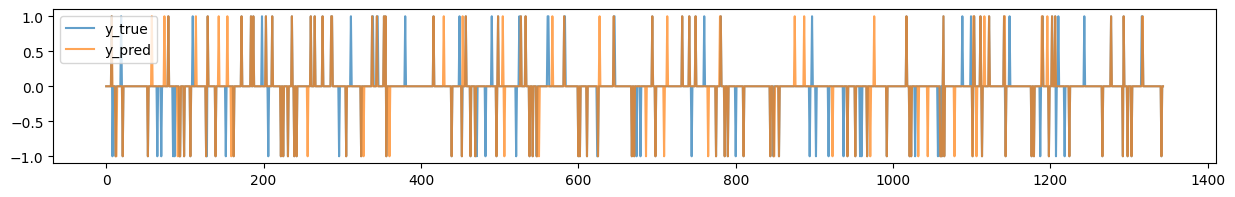

In [280]:
del X, y, X_train, X_test, y_train, y_test

X, y = get_clean_Xy(new_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

model = DecisionTreeClassifier()

print(pd.Series(y_test).value_counts())

print(y_test)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print('Classification accuracy: ', np.mean(y_test == y_pred))

print(classification_report(y_test, y_pred))

print(y_pred)


print(pd.Series(y_pred).value_counts())

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)


Classification accuracy:  0.9538690476190477
              precision    recall  f1-score   support

        -1.0       0.87      0.73      0.79        89
         0.0       0.96      0.99      0.97      1191
         1.0       0.91      0.62      0.74        64

    accuracy                           0.95      1344
   macro avg       0.91      0.78      0.84      1344
weighted avg       0.95      0.95      0.95      1344



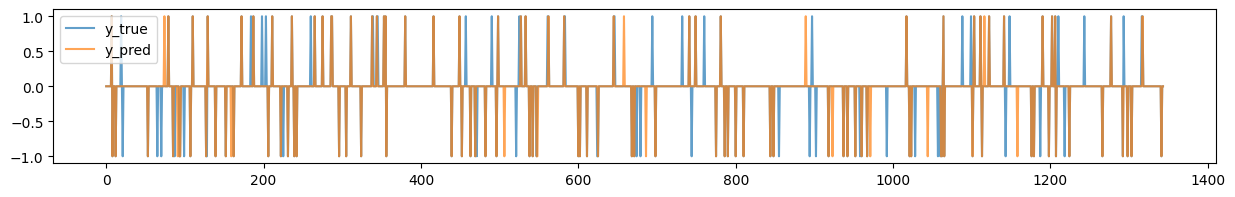

In [281]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

clf.fit(X_train, y_train_encoded)

y_pred = clf.predict(X_test) - 1

print('Classification accuracy: ', np.mean(y_test == y_pred))
print(classification_report(y_test, y_pred))
_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)


### Strategy based on Relative Strength Index

In [288]:
%%time

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

CASH = 1000000        
COMMISSION=0.001

# Importing 2018-06-01 to 2019-07-01
N_TRAIN = 24 * 160 # Training on a year of samples

class MLStrategy(Strategy):    
    price_delta = .004
    
    def init(self):
        #self.clf = DecisionTreeClassifier()
        
        self.clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

        df = self.data.df.iloc[:N_TRAIN]
        X,y = get_clean_Xy(df)

        # self.clf.fit(X,y)

        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y)
        self.clf.fit(X, y_train_encoded)

        self.tradecount = 0
        self.maxdaytrades = 4

        self.tpo = False
        self.I(get_y, self.data.df, name='y_true')

        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name = 'forecast')

    def next(self):
        if len(self.data) < N_TRAIN: return

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        if current_time.hour == 0:
            self.tradecount = 0
        
        forecast = self.clf.predict(get_X(self.data.df.iloc[-1:])) 

        self.forecasts[-1] = forecast - 1
        
        upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

        if forecast == 1 and not self.position.is_long and self.tradecount <= self.maxdaytrades:
            self.buy(size=.2, tp=upper, sl=lower)
            self.tradecount += 1
        elif forecast == -1 and not self.position.is_short and self.tradecount <= self.maxdaytrades:
            self.sell(size=.2, tp=lower, sl=upper)
            self.tradecount += 1

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        #for trade in self.trades:
        #    if current_time - trade.entry_time > pd.Timedelta('4 days'):
        #        if trade.is_long:
        #            trade.sl = max(trade.sl, low)
        #        else:
        #            trade.sl = min(trade.sl, high)

        if self.equity > CASH*1.1: # If equity i500 ever 10% higher than starting cash, close position and cease trading
            self.position.close()
            #self.tpo=True        

CPU times: user 62 µs, sys: 0 ns, total: 62 µs
Wall time: 66.8 µs


### Backtest

In [289]:
bt = Backtest(new_data, MLStrategy, cash=CASH, commission=COMMISSION)
stats = bt.run()
stats

Start                     2018-10-03 01:00:00
End                       2019-11-01 20:00:00
Duration                    394 days 19:00:00
Exposure Time [%]                   42.942051
Equity Final [$]                985151.155437
Equity Peak [$]                1000582.641429
Return [%]                          -1.484884
Buy & Hold Return [%]               -3.495603
Return (Ann.) [%]                   -1.109178
Volatility (Ann.) [%]                0.591968
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                     -1.8892
Avg. Drawdown [%]                   -0.572532
Max. Drawdown Duration      147 days 06:00:00
Avg. Drawdown Duration       42 days 03:00:00
# Trades                                   77
Win Rate [%]                        50.649351
Best Trade [%]                       0.302427
Worst Trade [%]                     -0.501267
Avg. Trade [%]                    

In [284]:
bt.plot()

/home/bkadmin/.local/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/home/bkadmin/.local/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p10118', ...)

Opening in existing browser session.
